# Tutorial: filling in missing bands

- last verification date : 2024-10-24 (Sylvie dagoret-Campagne)
- Must run this notebook from `docs/pre-executed` folder
- NOT DEBUGGED

We will use the parameter file "tests_nb/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugriz SDSS bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys,os
sys.path.append('../..')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

## Specifying were are the data file used for input outout

In [2]:
# path of the config parameter file
param_path = "tests_nb"
# path where the input fluxes file are generated including the Kerenl gaussian process file generated
data_path = "data_nb"

In [3]:
if not os.path.exists(data_path):
    os.mkdir(data_path)
if not os.path.exists(param_path):
    os.mkdir(param_path)

## Creating the parameter file
Let's create a parameter file from scratch.

In [4]:
paramfile_txt = """
# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column
"""

### 1) Specifying the Filters used for the photometric survey

In [5]:
paramfile_txt += """
[Bands]
names: U_SDSS G_SDSS R_SDSS I_SDSS Z_SDSS
directory: ../../data/FILTERS
bands_fmt: res
numCoefs: 7
bands_verbose: True
bands_debug: True
bands_makeplots: False
"""

### 2) Specifying the SED templates used

In [6]:
paramfile_txt += """
[Templates]
directory: ../../data/CWW_SEDs
sed_fmt: dat
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3
"""

### 3) Specifying the training and target photometric catalogs

In [7]:
paramfile_txt += """
[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: ./data_nb/galaxies-fluxredshifts.txt
targetFile: ./data_nb/galaxies-fluxredshifts2.txt
"""

#### 3.a Config for the simulation of the training catalog

In [8]:
paramfile_txt += """
[Training]
catFile: ./data_nb/galaxies-fluxredshifts.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var _ _ redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
paramFile: ./data_nb/galaxies-gpparams.txt
crossValidate: True
CVfile: ./data_nb/galaxies-gpCV.txt
crossValidationBandOrder: _ _ _ _ R_SDSS R_SDSS_var _ _ Z_SDSS Z_SDSS_var redshift
numChunks: 1
"""

#### 3.b Config for the simulation of the target catalog

In [9]:
paramfile_txt += """
[Target]
catFile: ./data_nb/galaxies-fluxredshifts2.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var _ _ redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
redshiftpdfFile: ./data_nb/galaxies-redshiftpdfs.txt
redshiftpdfFileTemp: ./data_nb/galaxies-redshiftpdfs-cww.txt
metricsFile:  ./data_nb/galaxies-redshiftmetrics.txt
metricsFileTemp:  ./data_nb/galaxies-redshiftmetrics-cww.txt
useCompression: False
Ncompress: 10
compressIndicesFile: ./data_nb/galaxies-compressionIndices.txt
compressMargLikFile: ./data_nb/galaxies-compressionMargLikes.txt
redshiftpdfFileComp: ./data_nb/galaxies-redshiftpdfs-comp.txt
"""

### 4) Specifying the hyper-parameters of the Gaussian Process fitting

In [10]:
paramfile_txt += """
[Other]
rootDir: ./
zPriorSigma: 0.2
ellPriorSigma: 0.5
fluxLuminosityNorm: 1.0
alpha_C: 1.0e3
V_C: 0.1
alpha_L: 1.0e2
V_L: 0.1
lines_pos: 6500 5002.26 3732.22
lines_width: 20.0 20.0 20.0
redshiftMin: 0.1
redshiftMax: 1.101
redshiftNumBinsGPpred: 100
redshiftBinSize: 0.001
redshiftDisBinSize: 0.2
confidenceLevels: 0.1 0.50 0.68 0.95
"""

Let's write this to a file.

In [11]:
with open('./tests_nb/parametersTest.cfg','w') as out:
    out.write(paramfile_txt)

In [12]:
from delight.io import parseParamFile
params = parseParamFile('./tests_nb/parametersTest.cfg', verbose=False)

In [13]:
params['training_CV_bandOrder']

['_',
 '_',
 '_',
 '_',
 'R_SDSS',
 'R_SDSS_var',
 '_',
 '_',
 'Z_SDSS',
 'Z_SDSS_var',
 'redshift']

# Running Delight

U_SDSS G_SDSS 

/Users/dagoret/MacOSX/GitHub/LSST/desc/2024/Delight_cython/Delight/scripts/processFilters.py:56: RuntimeWarning: Number of calls to function has reached maxfev = 3000.
  popt, pcov = leastsq(dfunc, p0, args=(x, y))


R_SDSS I_SDSS Z_SDSS 

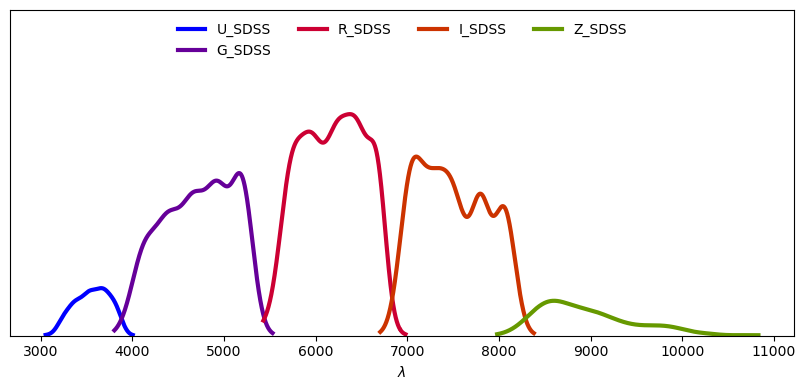

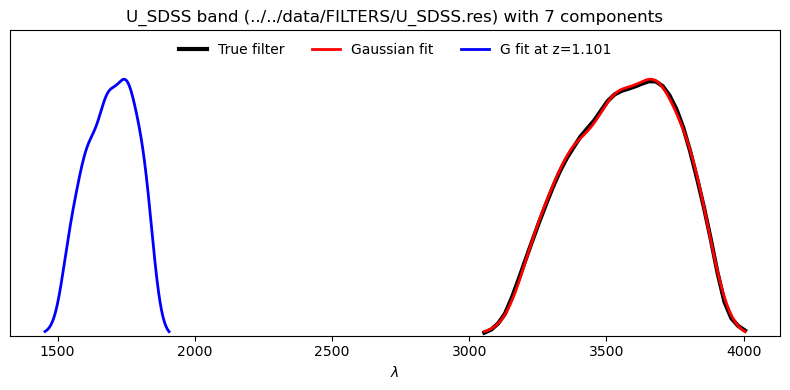

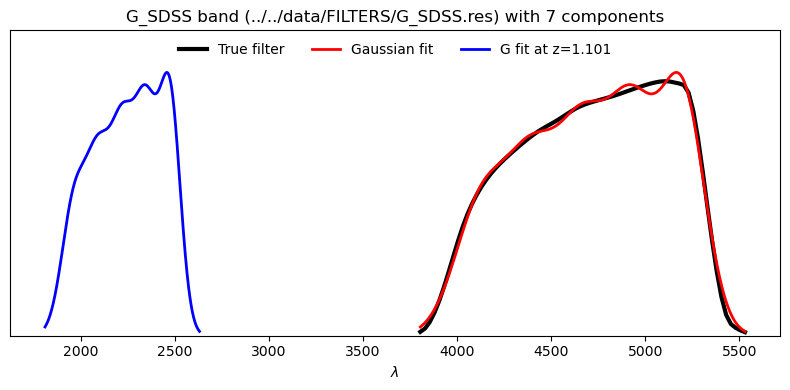

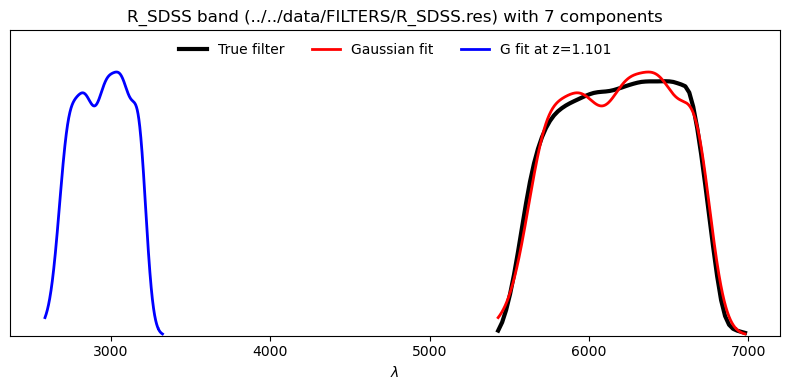

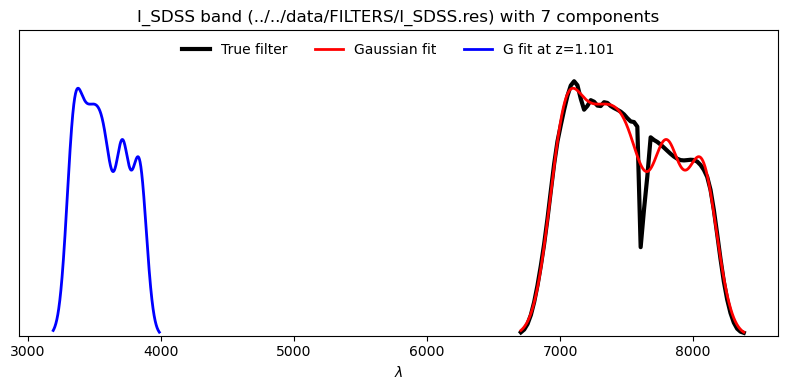

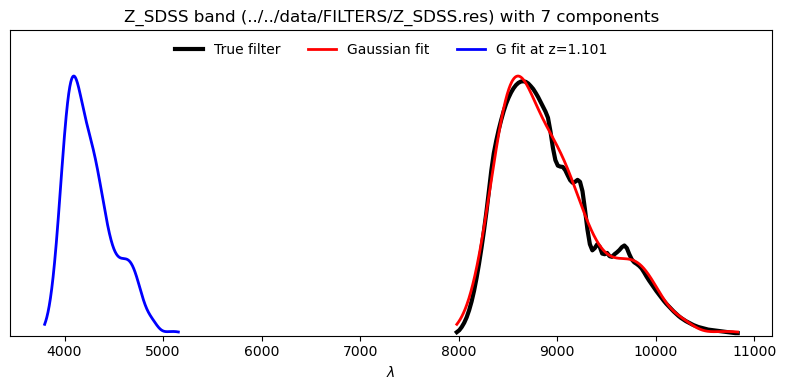

<Figure size 640x480 with 0 Axes>

In [14]:
# First, we must fit the band filters with a gaussian mixture. 
# This is done with this script:
%run ../../scripts/processFilters.py ./tests_nb/parametersTest.cfg

In [15]:
# Second, we will process the library of SEDs and project them onto the filters,
# (for the mean fct of the GP) with the following script:
%run ../../scripts/processSEDs.py ./tests_nb/parametersTest.cfg

In [16]:
# Third, we will make some mock data with those filters and SEDs:
%run ../../scripts/simulateWithSEDs.py ./tests_nb/parametersTest.cfg

In [17]:
# Now we load the parameter file and the useful quantities
params = parseParamFile('./tests_nb/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
f_mod = readSEDs(params) # Reads the SED library.
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
print('Number of Training Objects', numObjectsTraining)

Number of Training Objects 1000


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_74482/1763388715.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [18]:
# Create the GP (create interpolation grid for kernel + other internal stuff). May take a while.
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

In [19]:
# Load useful quantities for the training set.
# "CV" means quantities for the bands used for cross-validation.
# In this example we will drop a couple of bands in the training data 
# and use them for cross-validation, as shown in the parameter file.
bandIndicesCV, bandNamesCV, bandColumnsCV,\
    bandVarColumnsCV, redshiftColumnCV =\
    readColumnPositions(params, prefix="training_CV_", refFlux=False)
numBandsCV = bandIndicesCV.size

In [20]:
print("bandIndicesCV:",bandIndicesCV,"bandNamesCV:",bandNamesCV,"bandColumnsCV:",bandColumnsCV)
print("bandVarColumnsCV:","bandVarColumnsCV:",bandVarColumnsCV, "redshiftColumnCV:",redshiftColumnCV)

bandIndicesCV: [2 4] bandNamesCV: ['R_SDSS' 'Z_SDSS'] bandColumnsCV: [4 8]
bandVarColumnsCV: bandVarColumnsCV: [5 9] redshiftColumnCV: 10


In [21]:
# Loop and parse the training set, fit the GP to the deep bands, 
# and run cross-validation against the cross-validation bands.
# We will store a bunch of things, including the chi2 of the fit.

numZ = redshiftGrid.size
all_z = np.zeros((numObjectsTraining, ))
all_fluxes = np.zeros((numObjectsTraining, numBands))
all_fluxes_var = np.zeros((numObjectsTraining, numBands))
all_fluxesCV = np.zeros((numObjectsTraining, numBands))
all_fluxesCV_var = np.zeros((numObjectsTraining, numBands))
all_chi2s = np.zeros((numObjectsTraining, numBandsCV))
all_bestTypes = np.zeros((numObjectsTraining, ), dtype=int)


In [31]:
print("---------------------------------------------------------------------------------------")
loc = - 1
trainingDataIter1 = getDataFromFile(params, 0, numObjectsTraining,
                                    prefix="training_", getXY=True,
                                    CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
        X, Y, Yvar in trainingDataIter1:
    
    print("|==> ",z, normedRefFlux, bands, fluxes, fluxesVar, bandsCV, fluxesCV, fluxesVarCV, X, Y , Yvar)
    if loc<2:
        print(loc,"\t === bandsCV :",bandsCV," ====")

    
    loc += 1

    # Interpolate template library at spectroscopic redshift
    themod = np.zeros((1, f_mod.shape[0], bands.size))
    for it in range(f_mod.shape[0]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = f_mod[it, band](z)
            
    # Run color likelihood to find best template and ML luminosity
    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes, fluxesVar, themod, returnChi2=True)
    print("chi2_grid :: ",chi2_grid,ellMLs)   

    print("---------------------------------------------------------------------------------------")        
        
    if loc > 2:
        break

---------------------------------------------------------------------------------------
	 refFlux =  16.525099774476548
	 - mask = [ True  True  True] , numBandsUsed = 3
|==>  1.096541319619289 7324.765835118629 [0 1 3] [ 8.49910338  9.30597252 16.52509977] [0.06225147 0.08789161 0.2419433 ] None None None [[0.00000000e+00 1.09654132e+00 1.06397434e+13]
 [1.00000000e+00 1.09654132e+00 1.06397434e+13]
 [3.00000000e+00 1.09654132e+00 1.06397434e+13]] [[ 8.49910338]
 [ 9.30597252]
 [16.52509977]] [[0.06225147]
 [0.08789161]
 [0.2419433 ]]
-1 	 === bandsCV : None  ====
chi2_grid ::  [[1887.6728435   688.83858009  104.90288599   15.14060745   23.2263536
     4.07984184  322.87402641  483.52893008]] [[2661029.60099701 2202117.85830807 1552729.97667888 1144694.00353515
   674138.94115992  990504.90357376  385438.84974776  197241.92848199]]
---------------------------------------------------------------------------------------
	 refFlux =  120.6195206495852
	 - mask = [ True  True  True] , num

In [23]:
assert False

AssertionError: 

In [ ]:
getDataFromFile?

In [27]:
# Loop and parse the training set, fit the GP to the deep bands, 
# and run cross-validation against the cross-validation bands.
# We will store a bunch of things, including the chi2 of the fit.

numZ = redshiftGrid.size
all_z = np.zeros((numObjectsTraining, ))
all_fluxes = np.zeros((numObjectsTraining, numBands))
all_fluxes_var = np.zeros((numObjectsTraining, numBands))
all_fluxesCV = np.zeros((numObjectsTraining, numBands))
all_fluxesCV_var = np.zeros((numObjectsTraining, numBands))
all_chi2s = np.zeros((numObjectsTraining, numBandsCV))
all_bestTypes = np.zeros((numObjectsTraining, ), dtype=int)

loc = - 1
trainingDataIter1 = getDataFromFile(params, 0, numObjectsTraining,
                                    prefix="training_", getXY=True,
                                    CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
        X, Y, Yvar in trainingDataIter1:
    
    
    if loc<2:
        print(loc,"\t bandsCV",bandsCV)
    
    loc += 1

    # Interpolate template library at spectroscopic redshift
    themod = np.zeros((1, f_mod.shape[0], bands.size))
    for it in range(f_mod.shape[0]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = f_mod[it, band](z)

            
    # Run color likelihood to find best template and ML luminosity
    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes, fluxesVar, themod, returnChi2=True)
    bestType = np.argmin(chi2_grid)
    ell = ellMLs[0, bestType]
    # Use them in the GP
    X[:, 2] = ell
    gp.setData(X, Y, Yvar, bestType)
    
    # Make predictions for all bands (noiseless) from the GP
    model_mean, model_covar\
        = gp.predictAndInterpolate(np.array([z]), ell=ell)
    ind = np.array([list(bandIndicesCV).index(b) for b in bandsCV])

    print(ind)
    # Compute chi2 for SDSS bands
    all_chi2s[loc, ind] =\
        (model_mean[0, bandsCV] - fluxesCV)**2 /\
        (model_covar[0, bandsCV] + fluxesVarCV)
        
    # Store a few useful quantities
    all_z[loc] = z
    all_bestTypes[loc] = bestType
    all_fluxes[loc, bands] = fluxes
    all_fluxes_var[loc, bands] = fluxesVar
    all_fluxesCV[loc, bandsCV] = fluxesCV
    all_fluxesCV_var[loc, bandsCV] = fluxesVarCV

** getDataFromFile with CV set (prefix = training_  ) ::
	 bandIndicesCV, bandNamesCV, bandColumnsCV,                bandVarColumnsCV, redshiftColumnCV ==> 
 	 	 [2 4] ['R_SDSS' 'Z_SDSS'] [4 8] [5 9] 10
	 refFlux =  16.525099774476548
	 - mask = [ True  True  True] , numBandsUsed = 3
	 CV_2 :: data =  [ 8.49910338  0.06225075  9.30597252  0.08789074  0.          0.
 16.52509977  0.24194057  0.          0.          1.09654132  5.        ]
	 CV_2 :: bandColumnsCV,bandVarColumnsCV =  [4 8]   [5 9]
	 CV_2 :: data[bandColumnsCV] =  [0. 0.] np.isfinite(data[bandColumnsCV] =  [ True  True]
	 CV_2 :: maskCV =  [False False]
	 CV_2 :: bandsUsedCV =  []
	 CV_2 :: numBandsUsedCV =  0
-1 	 bandsCV []
[]


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
bandsCV

In [ ]:
# Plot the chi2 distributions for each band (1 degree of freedom)
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True)
x = np.linspace(0, 3, 50)
for i, ib in enumerate(bandsCV):    
    axs[0, i].plot(x, scipy.stats.chi2.pdf(x, 1), 'k')
    axs[0, i].hist(all_chi2s[:, i], 20, range=[0, x[-1]], histtype='step', normed=True, lw=1)
    axs[1, i].plot(x, scipy.stats.chi2.pdf(x, 1), 'k')
    axs[1, i].hist(all_chi2s[:, i], 20, range=[0, x[-1]], histtype='step', normed=True, lw=1)
    axs[1, i].set_yscale('log')
    axs[1, i].set_xlabel('$\chi^2$')
    axs[0, i].set_title(bandNames[ib])
    if i == 0:
        axs[0, i].set_ylabel('$F(\chi^2)$')
        axs[1, i].set_ylabel('$\log_{10}\ F(\chi^2)$')
    else:
        axs[0, i].set_yticks([])
        axs[1, i].set_yticks([])
fig.tight_layout()